In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib import cm

def read_mr_estimator_results(result_directory, output_directory = None):
    """made output_directory optional. But highly recommended since integration of all data may take some time

    Args:
        result_directory (str): _description_
        output_directory (_type_, optional): _description_. Defaults to None.

    Returns:
        _type_: _description_
    """
    files = [f for f in os.listdir(result_directory) if f.endswith(".parquet")]

    all_data = []
    for filename in files:
        filename_split = filename.split('_') # with filename pattern being:  "animal name _ experimental day _ task _ tetrode nr. _ brain area _ pre or post treatment _ timechunk .parquet"
        
        df = pd.read_parquet(f'{result_directory}/{filename}')
        df['tau'] = df['tau'][0]
        df['animal'] = filename_split[0]
        df['area'] = filename_split [1]
        df['state'] = filename_split[2]
        df['day'] = filename_split[3]
        df['epoch'] = filename_split[4]
        df['timestamp'] = filename_split[5].split('.')[0]
        all_data.append(df)

    # Combine all data
    df = pd.concat(all_data, ignore_index=True)

    # Convert categorical variables
    df['area'] = df['area'].astype('category')
    df['animal'] = df['animal'].astype('category')
    df['arm'] = df['state'].astype('category')

    if output_directory:
        df.to_parquet(f'{output_directory}big_df.parquet')
    
    return df

def interaction_plot(df, measure):
    plt.figure(figsize=(8,6))

    # Plot mean ± SEM for each area, grouped by state
    sns.pointplot(data=df, x="area", y=measure, hue="state", dodge=True, capsize=0.1, markers="o", errwidth=1, palette="viridis")

    plt.xlabel("Brain Area")
    plt.ylabel(f"Mean {measure} ± SEM")
    plt.title("Interaction Plot: State × Brain Area")
    plt.legend(title="State")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()

def grouped_violin_plot(df, measure, smooth = 0.1):
    # Set figure size
    plt.figure(figsize=(8, 6))

    # Create a violin plot
    sns.violinplot(data=df, x="area", y=measure, hue="state", split=True, inner= "box", bw_method=smooth, palette="viridis")

    # Labels and title
    plt.xlabel("Brain Area")
    plt.ylabel(f"{measure} Value")
    plt.title(f"Grouped Violin Plots: {measure} by Brain Area & State")

    # Adjust legend
    plt.legend(title="State")

    # Show grid for readability
    plt.grid(True, linestyle="--", alpha=0.5)

    # Display plot
    plt.show()

def violin_interaction_plot(df, measure, smooth = 0.1):
    # Set figure size
    plt.figure(figsize=(10, 6))

    # Create a new categorical x-axis combining 'area' and 'state'
    df["group"] = df["area"].astype(str) + "-" + df["state"].astype(str)


    # Sort so CA1-run, CA1-sleep, etc., are in the correct order
    df["group"] = pd.Categorical(df["group"], categories=[
        "CA1-run", "CA1-sleep", "CA2-run", "CA2-sleep", "CA3-run", "CA3-sleep"
    ], ordered=True)

    # Create violin plot
    sns.violinplot(data=df, x="group", y= measure, inner="quartile", color="lightgray", bw_method=smooth)

    # Compute means and standard errors
    means = df.groupby("group")[measure].mean()
    sems = df.groupby("group")[measure].sem()

    # Overlay mean points with error bars
    plt.errorbar(x=range(len(means)), y=means, yerr=sems, fmt="o", color="black", capsize=5, label="Mean ± SEM")

    # Extract x-coordinates for connecting lines
    run_indices = [0, 2, 4]  # CA1-run, CA2-run, CA3-run
    sleep_indices = [1, 3, 5]  # CA1-sleep, CA2-sleep, CA3-sleep

    plt.plot(run_indices, means.iloc[run_indices], marker="o", linestyle="-", color= cm.viridis(0.3), label="Run")
    plt.plot(sleep_indices, means.iloc[sleep_indices], marker="o", linestyle="-", color= cm.viridis(0.7), label="Sleep")

    # Labels & legend
    plt.xlabel("Brain Area & State")
    plt.ylabel("Tau Value")
    plt.title(f"{measure}: Violin Plot with Mean ± SEM and Interaction Lines")
    plt.xticks(rotation=45)
    plt.legend()
    
    plt.grid(axis="y", linestyle="-", linewidth=0.5, alpha=0.3)
    plt.gca().set_axisbelow(True)
    
    # Show plot
    plt.show()

def density_plot(df, measure, log = False):
    # Set figure size
    plt.figure(figsize=(12, 5))

    # Create separate plots for each state
    states = df["state"].unique()
    for i, state in enumerate(states, 1):
        plt.subplot(1, len(states), i)  # One subplot per state
        
        # Filter data for the current state
        subset = df[df["state"] == state]
        
        # Plot density for each brain area
        sns.kdeplot(data=subset, x=measure, hue="area", common_norm=False, bw_adjust=0.8, fill=True, alpha=0.05, palette="viridis")
        
        # Titles and labels
        plt.title(f"{measure}: Density Plot - {state.capitalize()}")
        plt.xlabel(measure)
        plt.ylabel("Density")
        
        if log:
            plt.xscale("log")
            plt.yscale("log")
            plt.grid(True, which="both", linestyle="--", linewidth=0.5)

    plt.tight_layout()
    plt.show()


In [37]:
df = pd.read_parquet("/groups/cns/share/Vincent/McHugh_lab/CA2Cre_DREADD/models_and_figures/big_df.parquet")

filter data

In [38]:
df = df[df['tau'] <= 3000]

selected_areas = ["CA1", "CA2", "CA3"]  # Replace with your desired values
df = df[df["area"].isin(selected_areas)]

df['area'] = df['area'].cat.remove_unused_categories()
df_pre = df[df['treatment'] == 'pre']

In [ ]:
print(df.columns)

Index(['popt', 'ssres', 'steps', 'dt', 'dtunit', 'quantiles', 'mrequantiles',
       'tauquantiles', 'description', 'tau', 'branching_factor', 'num_neurons',
       'activity', 'animal', 'day', 'task', 'area', 'treatment', 'timechunk',
       'distance_criticality'],
      dtype='object')


In [42]:
df = df_pre[df_pre['task'].str.startswith(('lt', 'sleep'))].copy()
df['task'] = df['task'].str.replace('^sleep.*', 'sleep', regex=True)
df['task'] = df['task'].str.replace('^lt.*', 'run', regex=True)
df.rename(columns={'task': 'state'}, inplace=True)
df.iloc[0, df.columns.get_loc('state')] = 'run'

/tmp/ipykernel_67733/1281310033.py:51: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1}` instead.

  sns.pointplot(data=df, x="area", y=measure, hue="state", dodge=True, capsize=0.1, markers="o", errwidth=1, palette="viridis")


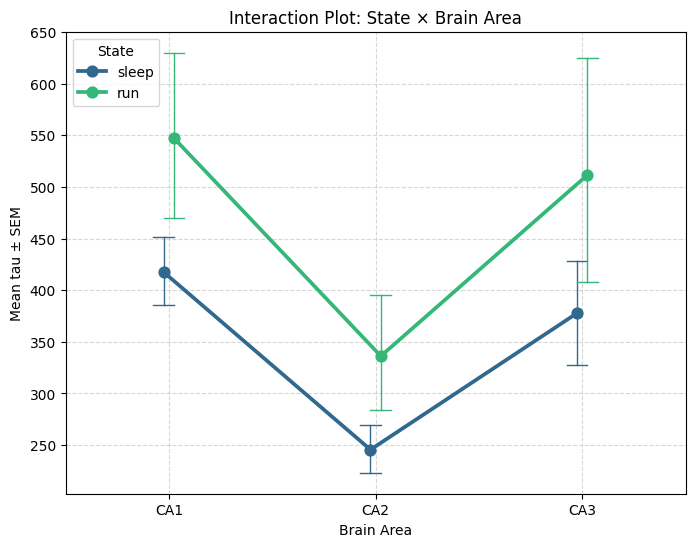

/tmp/ipykernel_67733/1281310033.py:51: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1}` instead.

  sns.pointplot(data=df, x="area", y=measure, hue="state", dodge=True, capsize=0.1, markers="o", errwidth=1, palette="viridis")


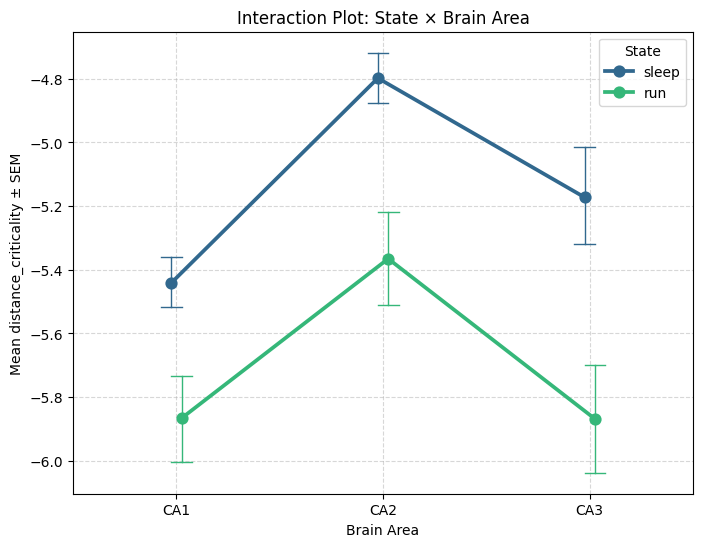

In [30]:
interaction_plot(df, 'tau')
interaction_plot(df, 'distance_criticality')

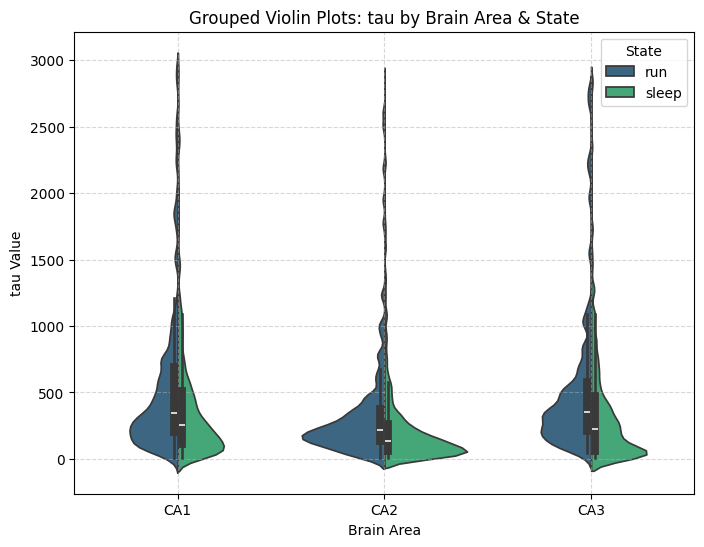

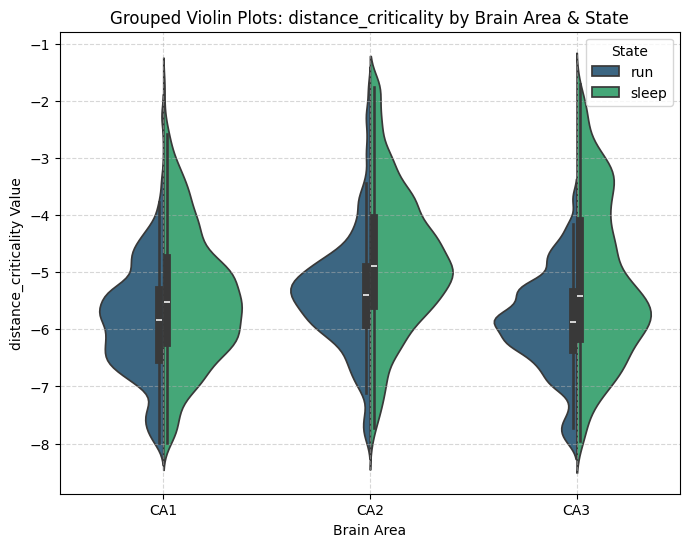

In [33]:
grouped_violin_plot(df, 'tau')
grouped_violin_plot(df, 'distance_criticality', smooth=0.2)

/tmp/ipykernel_67733/1281310033.py:98: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = df.groupby("group")[measure].mean()
/tmp/ipykernel_67733/1281310033.py:99: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sems = df.groupby("group")[measure].sem()


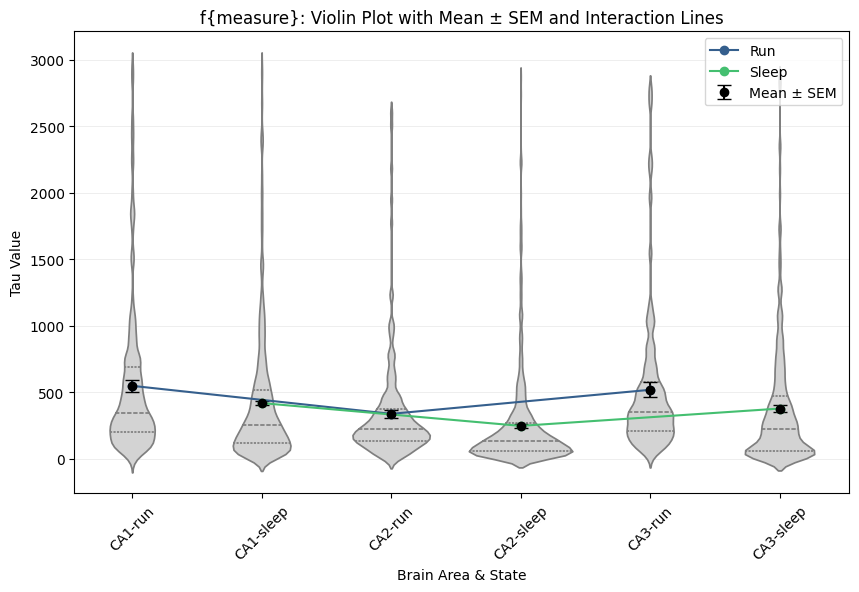

/tmp/ipykernel_67733/1281310033.py:98: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = df.groupby("group")[measure].mean()
/tmp/ipykernel_67733/1281310033.py:99: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sems = df.groupby("group")[measure].sem()


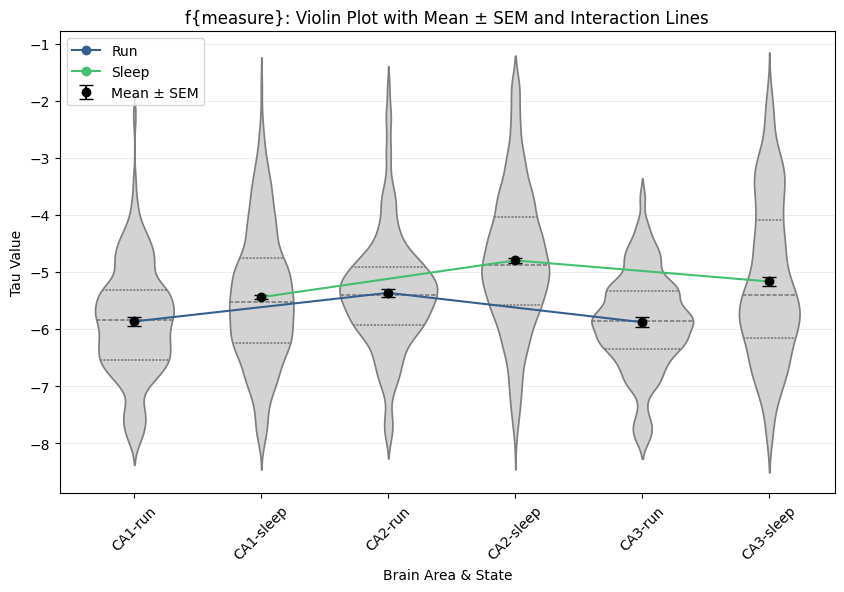

/tmp/ipykernel_67733/1281310033.py:98: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = df.groupby("group")[measure].mean()
/tmp/ipykernel_67733/1281310033.py:99: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sems = df.groupby("group")[measure].sem()


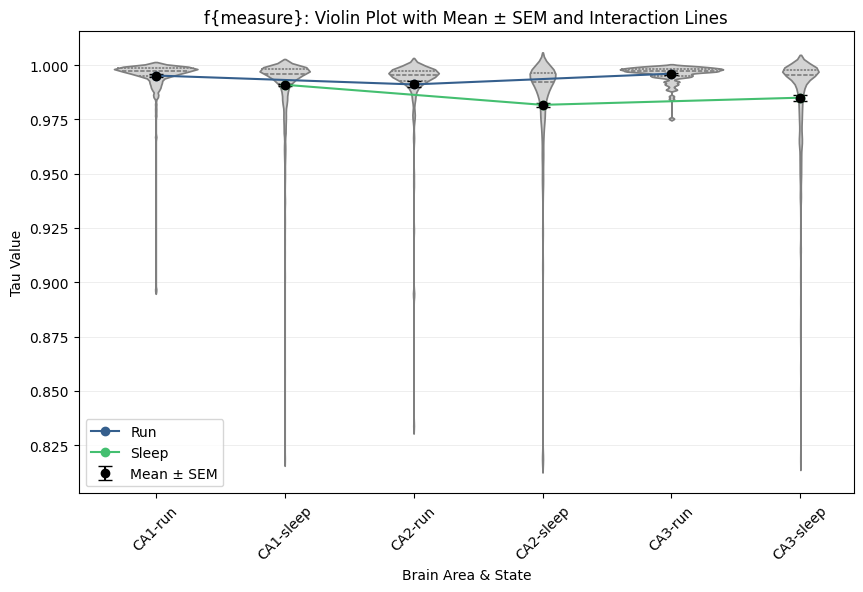

In [34]:
violin_interaction_plot(df, 'tau')
violin_interaction_plot(df, 'distance_criticality', smooth=0.2)
violin_interaction_plot(df, 'branching_factor')

Compare data from McHugh and Loren Frank

In [40]:
df_lf = pd.read_parquet('/groups/cns/dekorvyb/general_analysis/big_df.parquet') 

areas_oi = {'CA1', 'CA2', 'CA3'}
df_lf = df_lf[df_lf['area'].isin(areas_oi)]
df_lf['area'] = df_lf['area'].cat.remove_unused_categories()

df_lf = df_lf[df_lf['tau'] <= 3000]

Create combined df only for run sessions of loren frank and McHugh dataset

In [43]:
# Filter rows where 'state' == 'run' in both dataframes
df_run = df[df['state'] == 'run'].copy()
df_lf_run = df_lf[df_lf['state'] == 'run'].copy()

# Add 'dataset' column to each dataframe
df_run['dataset'] = 'MH'
df_lf_run['dataset'] = 'LF'

# Concatenate the two dataframes
df_combined = pd.concat([df_run, df_lf_run], ignore_index=True)

In [ ]:
def violin_interaction_plot_combined_datasets(df, measure, smooth = 0.1):
    # Set figure size
    plt.figure(figsize=(10, 6))

    # Create a new categorical x-axis combining 'area' and 'state'
    df["group"] = df["area"].astype(str) + "-" + df["dataset"].astype(str)


    # Sort so CA1-run, CA1-sleep, etc., are in the correct order
    df["group"] = pd.Categorical(df["group"], categories=[
        "CA1-MH", "CA1-LF", "CA2-MH", "CA2-LF", "CA3-MH", "CA3-LF"
    ], ordered=True)

    # Create violin plot
    sns.violinplot(data=df, x="group", y= measure, inner="quartile", color="lightgray", bw_method=smooth)

    # Compute means and standard errors
    means = df.groupby("group")[measure].mean()
    sems = df.groupby("group")[measure].sem()

    # Overlay mean points with error bars
    plt.errorbar(x=range(len(means)), y=means, yerr=sems, fmt="o", color="black", capsize=5, label="Mean ± SEM")

    # Extract x-coordinates for connecting lines
    run_indices = [0, 2, 4]  # CA1-run, CA2-run, CA3-run
    sleep_indices = [1, 3, 5]  # CA1-sleep, CA2-sleep, CA3-sleep

    plt.plot(run_indices, means.iloc[run_indices], marker="o", linestyle="-", color= cm.viridis(0.3), label="McHugh")
    plt.plot(sleep_indices, means.iloc[sleep_indices], marker="o", linestyle="-", color= cm.viridis(0.7), label="Loren Frank")

    # Labels & legend
    plt.xlabel("Brain Area & State")
    plt.ylabel("Tau Value")
    plt.title(f"{measure}: Violin Plot with Mean ± SEM and Interaction Lines")
    plt.xticks(rotation=45)
    plt.legend()
    
    plt.grid(axis="y", linestyle="-", linewidth=0.5, alpha=0.3)
    plt.gca().set_axisbelow(True)
    
    # Show plot
    plt.show()

violin_interaction_plot_combined_datasets(df_combined, 'tau')